In [1]:
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

## US zip data

In [2]:
uszips = pd.read_csv('../data_collection/uszips.csv', index_col=None)
uszips_simple = uszips[['zip', 'city', 'county_name', 'state_id']]
uszips_simple['zip'] = uszips_simple['zip'].astype(str).str.zfill(5)

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
edges = []
radius = 8
zip_not_recorded = []
for center_nd in tqdm(uszips_simple['zip']):
#     print(center_nd)
    try:
        first_nbrh_ls = [z.zip for z in zcdb.get_zipcodes_around_radius(center_nd, radius)]
        for nbr in first_nbrh_ls:
            edges.append([center_nd, nbr])
    except:
        zip_not_recorded.append(center_nd)
        
edges[:5]

  0%|          | 0/33788 [00:00<?, ?it/s]

[['00601', '00601'],
 ['00601', '00611'],
 ['00601', '00624'],
 ['00601', '00631'],
 ['00601', '00641']]

In [4]:
print(len(zip_not_recorded))
print(len(edges))

254
577290


### get edges

In [5]:
import pickle

dict_ = {'zip_not_recorded' : zip_not_recorded, 'edges' : edges}

f = open("../pkl_files/zip_adj.pkl","wb")
pickle.dump(dict_,f)
f.close()

# Networkx

In [6]:
def flatten(seq):
    l = []
    for elt in seq:
        t = type(elt)
        if t is tuple or t is list:
            for elt2 in flatten(elt):
                l.append(elt2)
        else:
            l.append(elt)
    return l

import scipy.sparse as sp
def normalize_adj(mx):
    """Normalize sparse adjacency matrix,
    A' = (D + I)^-1/2 * ( A + I ) * (D + I)^-1/2
    Row-normalize sparse matrix

    Parameters
    ----------
    mx : scipy.sparse.csr_matrix
        matrix to be normalized

    Returns
    -------
    scipy.sprase.lil_matrix
        normalized matrix
    """

    # TODO: maybe using coo format would be better?
    if type(mx) is not sp.lil.lil_matrix:
        mx = mx.tolil()
    if mx[0, 0] == 0 :
        mx = mx + sp.eye(mx.shape[0])
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1/2).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    mx = mx.dot(r_mat_inv)
    return mx

In [7]:
# 'edges' could contain some zips that are not in our original zip list
# 'zip_not_recorded' means zips that cannot be recognized by the pyzipcode package
extra_zip = (set(flatten(edges)) - set(uszips_simple['zip'])).union(set(zip_not_recorded))
len(extra_zip)

9687

In [16]:
cleaned_edges = []
for e in edges:
    if (not (e[1] in extra_zip)):
        cleaned_edges.append(e)

len(cleaned_edges)       

389682

In [194]:
# feat = pd.read_csv('../data_for_model/full_data_RemoveNAN_transformSkew_norm.csv', index_col=None)
feat = pd.read_csv('../data_for_model/full_data_RemoveNAN_transformSkew_norm_labelNotNorm.csv', index_col=None)

feat

,zip,college_cnt,walmart_cnt,Num_Mcdonalds,Num_Starbucks,Num_Teavana,population_total,pop_under19,pop_19To34,pop_35To54,...,income_median,shopping_mall_cnt,pop_density,selfstorage_count,selfstorage_area,costco_count,LABEL_bubbleStore_cnt,city_encoded,county_name_encoded,state_id_encoded
0,601,0.000000,0.0,0.0,0.0,0.0,0.007048,0.007039,0.007202,0.007198,...,0.005142,0.0,0.005348,0.0,0.0,0.0,0.0,0.000036,0.000034,0.007089
1,602,0.000000,0.0,0.0,0.0,0.0,0.008307,0.008226,0.008652,0.008718,...,0.005215,0.0,0.007405,0.0,0.0,0.0,0.0,0.000046,0.000039,0.007089
2,603,0.017335,0.0,0.0,0.0,0.0,0.008629,0.008783,0.008886,0.008982,...,0.005226,0.0,0.007629,0.0,0.0,0.0,0.0,0.000047,0.000044,0.007089
3,606,0.000000,0.0,0.0,0.0,0.0,0.005704,0.005341,0.005614,0.005742,...,0.005132,0.0,0.004662,0.0,0.0,0.0,0.0,0.005091,0.005202,0.007089
4,610,0.000000,0.0,0.0,0.0,0.0,0.007751,0.007635,0.008002,0.008132,...,0.005230,0.0,0.006706,0.0,0.0,0.0,0.0,0.000184,0.000448,0.007089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33765,99923,0.000000,0.0,0.0,0.0,0.0,0.000880,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.000105,0.0,0.0,0.0,0.0,0.003964,0.006845,0.000000
33766,99925,0.000000,0.0,0.0,0.0,0.0,0.003727,0.003402,0.003353,0.003656,...,0.005453,0.0,0.002411,0.0,0.0,0.0,0.0,0.004375,0.006845,0.000000
33767,99926,0.000000,0.0,0.0,0.0,0.0,0.004174,0.004190,0.003982,0.003972,...,0.005431,0.0,0.002036,0.0,0.0,0.0,0.0,0.005363,0.006845,0.000000
33768,99927,0.000000,0.0,0.0,0.0,0.0,-0.001572,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.005973,0.0,0.0,0.0,0.0,0.006747,0.006845,0.000000


In [195]:
zip_in_feat = list(feat['zip'].astype(str).str.zfill(5))
zip_in_feat

['00601',
 '00602',
 '00603',
 '00606',
 '00610',
 '00611',
 '00612',
 '00616',
 '00617',
 '00622',
 '00623',
 '00624',
 '00627',
 '00631',
 '00636',
 '00637',
 '00638',
 '00641',
 '00646',
 '00647',
 '00650',
 '00652',
 '00653',
 '00656',
 '00659',
 '00660',
 '00662',
 '00664',
 '00667',
 '00669',
 '00670',
 '00674',
 '00676',
 '00677',
 '00678',
 '00680',
 '00682',
 '00683',
 '00685',
 '00687',
 '00688',
 '00690',
 '00692',
 '00693',
 '00694',
 '00698',
 '00703',
 '00704',
 '00705',
 '00707',
 '00714',
 '00715',
 '00716',
 '00717',
 '00718',
 '00719',
 '00720',
 '00723',
 '00725',
 '00727',
 '00728',
 '00729',
 '00730',
 '00731',
 '00735',
 '00736',
 '00738',
 '00739',
 '00740',
 '00741',
 '00745',
 '00751',
 '00754',
 '00757',
 '00765',
 '00766',
 '00767',
 '00769',
 '00771',
 '00772',
 '00773',
 '00775',
 '00777',
 '00778',
 '00780',
 '00782',
 '00783',
 '00784',
 '00786',
 '00791',
 '00794',
 '00795',
 '00820',
 '00840',
 '00850',
 '00851',
 '00901',
 '00906',
 '00907',
 '00909',


In [196]:
len(set(zip_in_feat))

33770

In [197]:
zip_intersec = set(zip_in_feat).intersection(set(flatten(cleaned_edges)))
len(zip_intersec)

33527

In [198]:
cleaned_edges_2 = []
for e in cleaned_edges:
    if ((e[0] in zip_intersec) and (e[1] in zip_intersec)):
        cleaned_edges_2.append(e)

len(cleaned_edges_2)       

389633

In [199]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(list(zip_intersec)) #
edge_array = np.array(cleaned_edges_2) 
G.add_edges_from(edge_array)
adj = nx.adjacency_matrix(G)
print("adj.shape: ", adj.shape)

adj.shape:  (33527, 33527)


In [200]:
# enlarge diagnal by 4
adj.setdiag(4)
adj = normalize_adj(adj)

In [201]:
adj.todense()

matrix([[0.2       , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.30769231, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.08163265, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.8       , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.28571429,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.25      ]])

In [202]:
feat['zip'] = feat['zip'].astype(str).str.zfill(5)
feat2 = feat[feat['zip'].isin(zip_intersec)]

In [203]:
# drop zipcode
feat2_arr = np.array(feat2)
feat2_arr = np.vstack(feat2_arr[:, 1:-3]).astype(np.float) # drop zipcode

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [204]:
feat2

,zip,college_cnt,walmart_cnt,Num_Mcdonalds,Num_Starbucks,Num_Teavana,population_total,pop_under19,pop_19To34,pop_35To54,...,income_median,shopping_mall_cnt,pop_density,selfstorage_count,selfstorage_area,costco_count,LABEL_bubbleStore_cnt,city_encoded,county_name_encoded,state_id_encoded
0,00601,0.000000,0.0,0.0,0.0,0.0,0.007048,0.007039,0.007202,0.007198,...,0.005142,0.0,0.005348,0.0,0.0,0.0,0.0,0.000036,0.000034,0.007089
1,00602,0.000000,0.0,0.0,0.0,0.0,0.008307,0.008226,0.008652,0.008718,...,0.005215,0.0,0.007405,0.0,0.0,0.0,0.0,0.000046,0.000039,0.007089
2,00603,0.017335,0.0,0.0,0.0,0.0,0.008629,0.008783,0.008886,0.008982,...,0.005226,0.0,0.007629,0.0,0.0,0.0,0.0,0.000047,0.000044,0.007089
3,00606,0.000000,0.0,0.0,0.0,0.0,0.005704,0.005341,0.005614,0.005742,...,0.005132,0.0,0.004662,0.0,0.0,0.0,0.0,0.005091,0.005202,0.007089
4,00610,0.000000,0.0,0.0,0.0,0.0,0.007751,0.007635,0.008002,0.008132,...,0.005230,0.0,0.006706,0.0,0.0,0.0,0.0,0.000184,0.000448,0.007089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33765,99923,0.000000,0.0,0.0,0.0,0.0,0.000880,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.000105,0.0,0.0,0.0,0.0,0.003964,0.006845,0.000000
33766,99925,0.000000,0.0,0.0,0.0,0.0,0.003727,0.003402,0.003353,0.003656,...,0.005453,0.0,0.002411,0.0,0.0,0.0,0.0,0.004375,0.006845,0.000000
33767,99926,0.000000,0.0,0.0,0.0,0.0,0.004174,0.004190,0.003982,0.003972,...,0.005431,0.0,0.002036,0.0,0.0,0.0,0.0,0.005363,0.006845,0.000000
33768,99927,0.000000,0.0,0.0,0.0,0.0,-0.001572,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.005973,0.0,0.0,0.0,0.0,0.006747,0.006845,0.000000


In [205]:
fst_nei = adj @ feat2_arr

In [206]:
snd_nei = adj @ fst_nei

In [207]:
fst_nei_ = np.concatenate((np.array(feat2['zip']).reshape(-1,1), fst_nei), axis=1)
fst_nei_ = np.concatenate((fst_nei_, np.array(feat2[['city_encoded', 
                                                     'county_name_encoded', 'state_id_encoded']])), axis=1)
fst_nei_df = pd.DataFrame(fst_nei_, columns=feat2.columns)

In [208]:
fst_nei_df

,zip,college_cnt,walmart_cnt,Num_Mcdonalds,Num_Starbucks,Num_Teavana,population_total,pop_under19,pop_19To34,pop_35To54,...,income_median,shopping_mall_cnt,pop_density,selfstorage_count,selfstorage_area,costco_count,LABEL_bubbleStore_cnt,city_encoded,county_name_encoded,state_id_encoded
0,00601,0.001347,0.001743,0.002167,0.002402,0.0,0.005731,0.005423,0.005432,0.005611,...,0.005791,0.001157,0.00534,0.002226,0.002055,0.002931,0.536067,0.000036,0.000034,0.007089
1,00602,0.002777,0.000973,0.0,0.0,0.0,0.005878,0.005337,0.005694,0.005778,...,0.005763,0.000695,0.005151,0.000711,0.000977,0.0,0.0,0.000046,0.000039,0.007089
2,00603,0.003963,0.001564,0.003069,0.001947,0.00117,0.005711,0.005547,0.00549,0.005596,...,0.006026,0.000434,0.005027,0.000826,0.000778,0.000948,1.938311,0.000047,0.000044,0.007089
3,00606,0.001474,0.000649,0.001112,0.000671,0.000582,0.0051,0.004732,0.004716,0.00489,...,0.005656,0.000894,0.004916,0.000979,0.00093,0.0,0.155607,0.005091,0.005202,0.007089
4,00610,0.0,0.0,0.00053,0.0,0.0,0.005244,0.004763,0.005147,0.005241,...,0.005301,0.0,0.004712,0.0,0.0,0.0,0.0,0.000184,0.000448,0.007089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33522,99923,0.0,0.0,0.0,0.0,0.0,0.00088,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.000105,0.0,0.0,0.0,0.0,0.003964,0.006845,0.0
33523,99925,0.0,0.0,0.0,0.0,0.0,0.003387,0.003075,0.002824,0.003241,...,0.005539,0.0,0.002923,0.0,0.0,0.0,0.0,0.004375,0.006845,0.0
33524,99926,0.0,0.0,0.0,0.0,0.0,0.003782,0.003681,0.003485,0.003529,...,0.005342,0.0,0.001791,0.0,0.0,0.0,0.0,0.005363,0.006845,0.0
33525,99927,0.0,0.0,0.000332,0.000514,0.0,0.002141,0.001909,0.001224,0.001911,...,0.005061,0.0,-0.000331,0.0,0.0,0.0,0.0,0.006747,0.006845,0.0


In [209]:
fst_nei_df = fst_nei_df.rename(columns = lambda col: f"{col}_fst_agg" 
                                if col not in ('zip', 'city_encoded', 'county_name_encoded', 'state_id_encoded') 
                                else col)

In [210]:
fst_nei_df

,zip,college_cnt_fst_agg,walmart_cnt_fst_agg,Num_Mcdonalds_fst_agg,Num_Starbucks_fst_agg,Num_Teavana_fst_agg,population_total_fst_agg,pop_under19_fst_agg,pop_19To34_fst_agg,pop_35To54_fst_agg,...,income_median_fst_agg,shopping_mall_cnt_fst_agg,pop_density_fst_agg,selfstorage_count_fst_agg,selfstorage_area_fst_agg,costco_count_fst_agg,LABEL_bubbleStore_cnt_fst_agg,city_encoded,county_name_encoded,state_id_encoded
0,00601,0.001347,0.001743,0.002167,0.002402,0.0,0.005731,0.005423,0.005432,0.005611,...,0.005791,0.001157,0.00534,0.002226,0.002055,0.002931,0.536067,0.000036,0.000034,0.007089
1,00602,0.002777,0.000973,0.0,0.0,0.0,0.005878,0.005337,0.005694,0.005778,...,0.005763,0.000695,0.005151,0.000711,0.000977,0.0,0.0,0.000046,0.000039,0.007089
2,00603,0.003963,0.001564,0.003069,0.001947,0.00117,0.005711,0.005547,0.00549,0.005596,...,0.006026,0.000434,0.005027,0.000826,0.000778,0.000948,1.938311,0.000047,0.000044,0.007089
3,00606,0.001474,0.000649,0.001112,0.000671,0.000582,0.0051,0.004732,0.004716,0.00489,...,0.005656,0.000894,0.004916,0.000979,0.00093,0.0,0.155607,0.005091,0.005202,0.007089
4,00610,0.0,0.0,0.00053,0.0,0.0,0.005244,0.004763,0.005147,0.005241,...,0.005301,0.0,0.004712,0.0,0.0,0.0,0.0,0.000184,0.000448,0.007089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33522,99923,0.0,0.0,0.0,0.0,0.0,0.00088,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.000105,0.0,0.0,0.0,0.0,0.003964,0.006845,0.0
33523,99925,0.0,0.0,0.0,0.0,0.0,0.003387,0.003075,0.002824,0.003241,...,0.005539,0.0,0.002923,0.0,0.0,0.0,0.0,0.004375,0.006845,0.0
33524,99926,0.0,0.0,0.0,0.0,0.0,0.003782,0.003681,0.003485,0.003529,...,0.005342,0.0,0.001791,0.0,0.0,0.0,0.0,0.005363,0.006845,0.0
33525,99927,0.0,0.0,0.000332,0.000514,0.0,0.002141,0.001909,0.001224,0.001911,...,0.005061,0.0,-0.000331,0.0,0.0,0.0,0.0,0.006747,0.006845,0.0


In [211]:
snd_nei_ = np.concatenate((np.array(feat2['zip']).reshape(-1,1), snd_nei), axis=1)
snd_nei_ = np.concatenate((snd_nei_, np.array(feat2[['city_encoded', 
                                                     'county_name_encoded', 'state_id_encoded']])), axis=1)
snd_nei_df = pd.DataFrame(snd_nei_, columns=feat2.columns)


snd_nei_df = snd_nei_df.rename(columns = lambda col: f"{col}_snd_agg" 
                                if col not in ('zip', 'city_encoded', 'county_name_encoded', 'state_id_encoded') 
                                else col)

snd_nei_df

,zip,college_cnt_snd_agg,walmart_cnt_snd_agg,Num_Mcdonalds_snd_agg,Num_Starbucks_snd_agg,Num_Teavana_snd_agg,population_total_snd_agg,pop_under19_snd_agg,pop_19To34_snd_agg,pop_35To54_snd_agg,...,income_median_snd_agg,shopping_mall_cnt_snd_agg,pop_density_snd_agg,selfstorage_count_snd_agg,selfstorage_area_snd_agg,costco_count_snd_agg,LABEL_bubbleStore_cnt_snd_agg,city_encoded,county_name_encoded,state_id_encoded
0,00601,0.001463,0.001876,0.002166,0.002062,0.0,0.005344,0.005004,0.004936,0.00517,...,0.005851,0.001178,0.004728,0.002069,0.001974,0.002117,0.419404,0.000036,0.000034,0.007089
1,00602,0.003503,0.001538,0.000441,0.000806,0.0,0.005625,0.005165,0.005379,0.005438,...,0.005853,0.001077,0.004864,0.00074,0.001017,0.0,0.159465,0.000046,0.000039,0.007089
2,00603,0.002983,0.001654,0.002997,0.002091,0.00127,0.005551,0.005325,0.005296,0.005428,...,0.00606,0.001326,0.004856,0.001317,0.001106,0.001232,1.732075,0.000047,0.000044,0.007089
3,00606,0.001347,0.001071,0.001379,0.000717,0.000612,0.005195,0.004837,0.004806,0.004973,...,0.005813,0.001029,0.004907,0.000755,0.000737,0.000053,0.196208,0.005091,0.005202,0.007089
4,00610,0.000387,0.000638,0.000957,0.000563,0.0,0.004722,0.004221,0.004554,0.004609,...,0.005378,0.001129,0.004308,0.000107,0.000113,0.000314,0.185069,0.000184,0.000448,0.007089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33522,99923,0.0,0.0,0.0,0.0,0.0,0.00088,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.000105,0.0,0.0,0.0,0.0,0.003964,0.006845,0.0
33523,99925,0.0,0.0,0.0,0.0,0.0,0.003216,0.002906,0.002559,0.003039,...,0.005567,0.0,0.003065,0.0,0.0,0.0,0.0,0.004375,0.006845,0.0
33524,99926,0.0,0.0,0.0,0.0,0.0,0.003602,0.00342,0.003221,0.003322,...,0.005304,0.0,0.001795,0.0,0.0,0.0,0.0,0.005363,0.006845,0.0
33525,99927,0.000192,0.000316,0.000713,0.001354,0.0,0.003237,0.003081,0.002401,0.003068,...,0.004948,0.000409,0.001564,0.000174,0.000139,0.0,0.105846,0.006747,0.006845,0.0


In [212]:
fst_nei_df.to_csv('../data_for_model/full_data_RemoveNAN_transformSkew_fstAgg_labelNotNorm.csv', index=False)
snd_nei_df.to_csv('../data_for_model/full_data_RemoveNAN_transformSkew_sndAgg_labelNotNorm.csv', index=False)

## Mark Unknown labels

In [213]:
import copy

In [214]:
data = copy.deepcopy(fst_nei_df)

In [215]:
city_store_cnt = data.groupby(['city_encoded'])['LABEL_bubbleStore_cnt_fst_agg'].agg('sum')

In [216]:
unknown_city = list(city_store_cnt[city_store_cnt == 0].index)

In [217]:
data.loc[data['city_encoded'].isin(unknown_city),'LABEL_bubbleStore_cnt_fst_agg'] = np.nan
data

,zip,college_cnt_fst_agg,walmart_cnt_fst_agg,Num_Mcdonalds_fst_agg,Num_Starbucks_fst_agg,Num_Teavana_fst_agg,population_total_fst_agg,pop_under19_fst_agg,pop_19To34_fst_agg,pop_35To54_fst_agg,...,income_median_fst_agg,shopping_mall_cnt_fst_agg,pop_density_fst_agg,selfstorage_count_fst_agg,selfstorage_area_fst_agg,costco_count_fst_agg,LABEL_bubbleStore_cnt_fst_agg,city_encoded,county_name_encoded,state_id_encoded
0,00601,0.001347,0.001743,0.002167,0.002402,0.0,0.005731,0.005423,0.005432,0.005611,...,0.005791,0.001157,0.00534,0.002226,0.002055,0.002931,0.536067,0.000036,0.000034,0.007089
1,00602,0.002777,0.000973,0.0,0.0,0.0,0.005878,0.005337,0.005694,0.005778,...,0.005763,0.000695,0.005151,0.000711,0.000977,0.0,NaN,0.000046,0.000039,0.007089
2,00603,0.003963,0.001564,0.003069,0.001947,0.00117,0.005711,0.005547,0.00549,0.005596,...,0.006026,0.000434,0.005027,0.000826,0.000778,0.000948,1.938311,0.000047,0.000044,0.007089
3,00606,0.001474,0.000649,0.001112,0.000671,0.000582,0.0051,0.004732,0.004716,0.00489,...,0.005656,0.000894,0.004916,0.000979,0.00093,0.0,0.155607,0.005091,0.005202,0.007089
4,00610,0.0,0.0,0.00053,0.0,0.0,0.005244,0.004763,0.005147,0.005241,...,0.005301,0.0,0.004712,0.0,0.0,0.0,NaN,0.000184,0.000448,0.007089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33522,99923,0.0,0.0,0.0,0.0,0.0,0.00088,-0.001867,-0.002137,-0.001895,...,0.005431,0.0,-0.000105,0.0,0.0,0.0,NaN,0.003964,0.006845,0.0
33523,99925,0.0,0.0,0.0,0.0,0.0,0.003387,0.003075,0.002824,0.003241,...,0.005539,0.0,0.002923,0.0,0.0,0.0,NaN,0.004375,0.006845,0.0
33524,99926,0.0,0.0,0.0,0.0,0.0,0.003782,0.003681,0.003485,0.003529,...,0.005342,0.0,0.001791,0.0,0.0,0.0,NaN,0.005363,0.006845,0.0
33525,99927,0.0,0.0,0.000332,0.000514,0.0,0.002141,0.001909,0.001224,0.001911,...,0.005061,0.0,-0.000331,0.0,0.0,0.0,NaN,0.006747,0.006845,0.0


In [218]:
fst_nei_df2 = data

In [219]:
data = copy.deepcopy(snd_nei_df)
city_store_cnt = data.groupby(['city_encoded'])['LABEL_bubbleStore_cnt_snd_agg'].agg('sum')
unknown_city = list(city_store_cnt[city_store_cnt == 0].index)
data.loc[data['city_encoded'].isin(unknown_city),'LABEL_bubbleStore_cnt_snd_agg'] = np.nan

In [220]:
snd_nei_df2 = data

In [221]:
fst_nei_df2.to_csv('../data_for_model/fstAgg_labelNotNorm.csv', index=False)
snd_nei_df2.to_csv('../data_for_model/sndAgg_labelNotNorm.csv', index=False)

## Train & Test Splite

In [222]:
from sklearn.model_selection import train_test_split

### First agg

In [245]:
data = copy.deepcopy(fst_nei_df2)
data = data.drop(columns=['city_encoded', 'county_name_encoded', 'state_id_encoded'])

In [246]:
train_test_data = data[~data['LABEL_bubbleStore_cnt_fst_agg'].isna()]
recommend_data = data[data['LABEL_bubbleStore_cnt_fst_agg'].isna()]

In [247]:
X = np.array(train_test_data)[:, 1:-1]
y = np.array(train_test_data)[:, [-1,0]]

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [249]:
X_train_df = pd.DataFrame(X_train, columns = data.columns[1:-1])
X_test_df = pd.DataFrame(X_test, columns = data.columns[1:-1])
y_train_df = pd.DataFrame(y_train, columns = ['LABEL_bubbleStore_cnt_fst_agg', 'zip'])
y_test_df = pd.DataFrame(y_test, columns = ['LABEL_bubbleStore_cnt_fst_agg', 'zip'])

In [250]:
X_train_df.to_csv('../csv_files/X_train_df_fstAgg_labelNotNorm.csv', index=False)  
X_test_df.to_csv('../csv_files/X_test_df_fstAgg_labelNotNorm.csv', index=False)  
y_train_df.to_csv('../csv_files/y_train_df_fstAgg_labelNotNorm.csv', index=False)  
y_test_df.to_csv('../csv_files/y_test_df_fstAgg_labelNotNorm.csv', index=False)  
recommend_data.to_csv('../csv_files/recommend_data_fstAgg_labelNotNorm.csv', index=False)  

In [251]:
# import pickle

# dic = {'X_train_df': X_train_df, 'X_test_df': X_test_df, 
#        'y_train_df': y_train_df, 'y_test_df':y_test_df, 
#        'recommend_data':recommend_data}

# # Store data (serialize)
# with open('../pkl_files/fstAgg.pkl', 'wb') as handle:
#     pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Load data (deserialize)
# with open('../pkl_files/fstAgg.pkl', 'rb') as handle:
#     unserialized_data = pickle.load(handle)


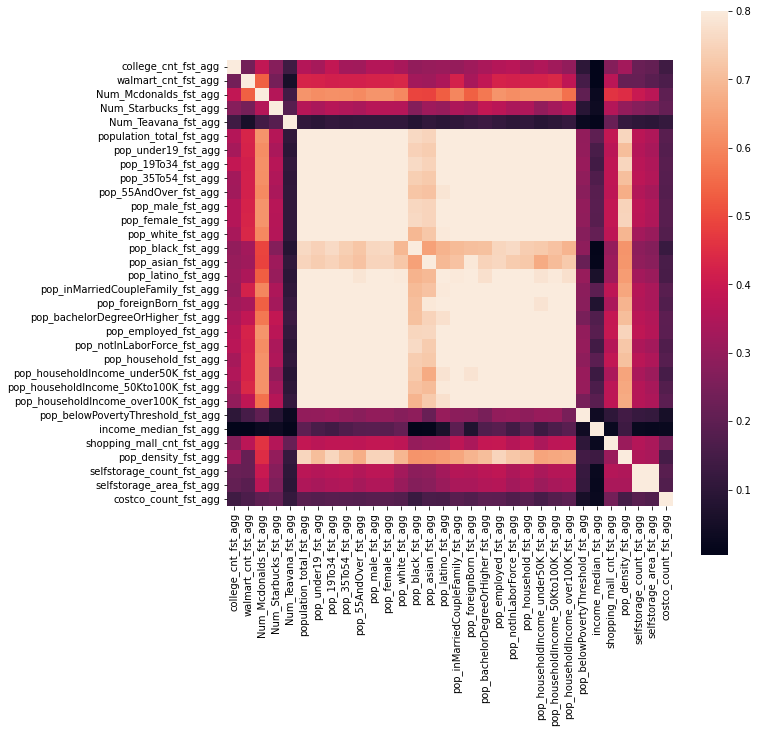

In [252]:
import seaborn as sb
from matplotlib import pyplot as plt
C_mat = X_train_df.astype(float).corr()
fig = plt.figure(figsize = (10,10))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

### Second agg

In [231]:
data = copy.deepcopy(snd_nei_df2)
data = data.drop(columns=['city_encoded', 'county_name_encoded', 'state_id_encoded'])
train_test_data = data[~data['LABEL_bubbleStore_cnt_snd_agg'].isna()]
recommend_data = data[data['LABEL_bubbleStore_cnt_snd_agg'].isna()]

X = np.array(train_test_data)[:, 1:-1]
y = np.array(train_test_data)[:, [-1,0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_df = pd.DataFrame(X_train, columns = data.columns[1:-1])
X_test_df = pd.DataFrame(X_test, columns = data.columns[1:-1])
y_train_df = pd.DataFrame(y_train, columns = ['LABEL_bubbleStore_cnt_snd_agg', 'zip'])
y_test_df = pd.DataFrame(y_test, columns = ['LABEL_bubbleStore_cnt_snd_agg', 'zip'])

dic = {'X_train_df': X_train_df, 'X_test_df': X_test_df, 
       'y_train_df': y_train_df, 'y_test_df':y_test_df, 
       'recommend_data':recommend_data}

# Store data (serialize)
with open('../pkl_files/sndAgg.pkl', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Load data (deserialize)
# with open('../pkl_files/fstAgg.pkl', 'rb') as handle:
#     unserialized_data = pickle.load(handle)

In [232]:
X_train_df.to_csv('../csv_files/X_train_df_sndAgg_labelNotNorm.csv', index=False)  
X_test_df.to_csv('../csv_files/X_test_df_sndAgg_labelNotNorm.csv', index=False)  
y_train_df.to_csv('../csv_files/y_train_df_sndAgg_labelNotNorm.csv', index=False)  
y_test_df.to_csv('../csv_files/y_test_df_sndAgg_labelNotNorm.csv', index=False)  
recommend_data.to_csv('../csv_files/recommend_data_sndAgg_labelNotNorm.csv', index=False)  

In [234]:
X_train_df

,college_cnt_snd_agg,walmart_cnt_snd_agg,Num_Mcdonalds_snd_agg,Num_Starbucks_snd_agg,Num_Teavana_snd_agg,population_total_snd_agg,pop_under19_snd_agg,pop_19To34_snd_agg,pop_35To54_snd_agg,pop_55AndOver_snd_agg,...,pop_householdIncome_under50K_snd_agg,pop_householdIncome_50Kto100K_snd_agg,pop_householdIncome_over100K_snd_agg,pop_belowPovertyThreshold_snd_agg,income_median_snd_agg,shopping_mall_cnt_snd_agg,pop_density_snd_agg,selfstorage_count_snd_agg,selfstorage_area_snd_agg,costco_count_snd_agg
0,0.00137,0.002075,0.004807,0.00298,0.0,0.005565,0.005489,0.005472,0.005605,0.005634,...,0.005234,0.005409,0.00539,0.00497,0.005183,0.004446,0.004426,0.001516,0.000918,0.00655
1,0.000176,0.001671,0.000987,0.000481,0.000372,0.004669,0.004587,0.004143,0.004491,0.004387,...,0.004212,0.0046,0.004262,0.00288,0.005629,0.001251,0.004455,0.0,0.0,0.0
2,0.004346,0.004055,0.00429,0.008314,0.014055,0.006222,0.005557,0.006271,0.006223,0.006219,...,0.006404,0.005569,0.0061,0.00628,0.006171,0.0,0.005243,0.0,0.0,0.0
3,0.002556,0.001533,0.002263,0.000215,0.00005,0.004479,0.004247,0.004239,0.004366,0.004472,...,0.004379,0.004315,0.004336,0.000917,0.004761,0.001536,0.00382,0.000785,0.000913,0.000479
4,0.001561,0.004192,0.00273,0.002026,0.006127,0.00553,0.005307,0.005242,0.005185,0.005353,...,0.005142,0.005131,0.0052,0.004059,0.00569,0.002646,0.005177,0.000737,0.000565,0.002402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19672,0.001328,0.002666,0.002594,0.002264,0.0,0.005494,0.005393,0.004936,0.005492,0.005445,...,0.005258,0.005348,0.005389,0.002875,0.005981,0.001497,0.004557,0.002057,0.001494,0.0
19673,0.000593,0.000196,0.001387,0.000684,0.0,0.005242,0.004885,0.00492,0.005171,0.005156,...,0.00462,0.00502,0.004742,0.001577,0.005703,0.000991,0.003808,0.002829,0.004603,0.0
19674,0.0,0.0,0.0,0.0,0.0,0.003977,0.003436,0.003251,0.003962,0.004058,...,0.00382,0.004071,0.003651,0.004959,0.005146,0.0,0.003018,0.0,0.0,0.0
19675,0.000509,0.00117,0.00288,0.00122,0.0,0.005722,0.005457,0.005466,0.005573,0.005628,...,0.005555,0.005597,0.005459,0.002357,0.006168,0.000674,0.00524,0.00179,0.002212,0.001818


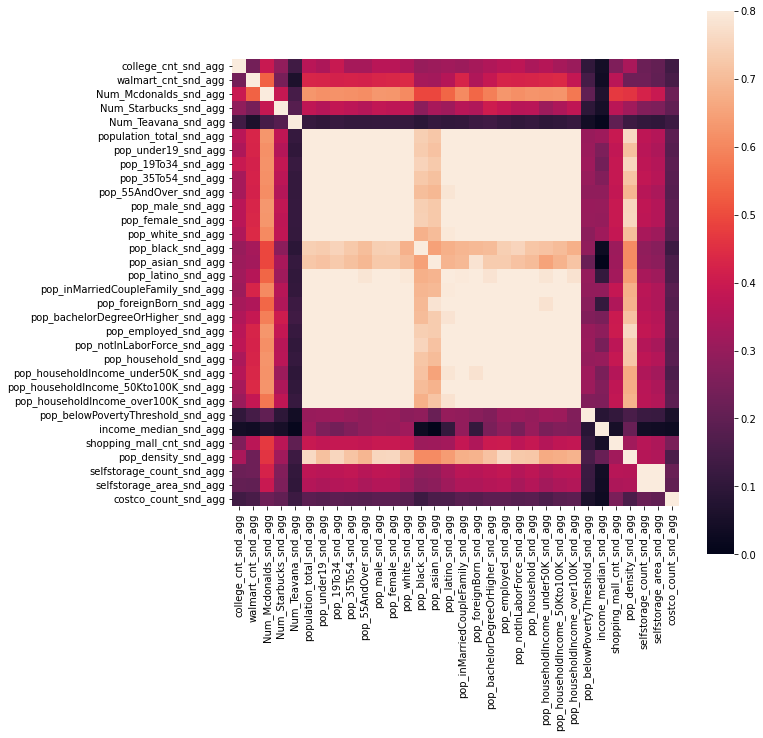

In [243]:
import seaborn as sb
from matplotlib import pyplot as plt
C_mat = X_train_df.astype(float).corr()
fig = plt.figure(figsize = (10,10))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

## Aggeragete non-scaled data

In [175]:
feat_raw = pd.read_csv('../data_for_model/full_data_cleaned_RemoveNAN.csv', index_col=None).drop(columns = ['rating', 'review count'])
feat_raw

,zip,college_cnt,walmart_cnt,city,county_name,state_id,Num_Mcdonalds,Num_Starbucks,Num_Teavana,population_total,...,pop_householdIncome_50Kto100K,pop_householdIncome_over100K,pop_belowPovertyThreshold,income_median,shopping_mall_cnt,pop_density,selfstorage_count,selfstorage_area,costco_count,LABEL_bubbleStore_cnt
0,601,0.0,0.0,Adjuntas,Adjuntas,PR,0.0,0.0,0.0,16722.0,...,981.0,263.0,5.2,19353.0,0.0,259.868217,0.0,0.0,0.0,0.0
1,602,0.0,0.0,Aguada,Aguada,PR,0.0,0.0,0.0,37063.0,...,5463.0,1301.0,4.7,26150.0,0.0,1210.694803,0.0,0.0,0.0,0.0
2,603,2.0,0.0,Aguadilla,Aguadilla,PR,0.0,0.0,0.0,44684.0,...,6761.0,2159.0,5.2,27451.0,0.0,1413.335020,0.0,0.0,0.0,0.0
3,606,0.0,0.0,Maricao,Maricao,PR,0.0,0.0,0.0,6231.0,...,410.0,0.0,2.6,18534.0,0.0,147.273630,0.0,0.0,0.0,0.0
4,610,0.0,0.0,Anasco,Añasco,PR,0.0,0.0,0.0,26426.0,...,4342.0,1016.0,3.6,27865.0,0.0,735.772358,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33765,99923,0.0,0.0,Hyder,Prince of Wales-Hyder,AK,0.0,0.0,0.0,12.0,...,0.0,0.0,37.5,69616.5,0.0,0.864803,0.0,0.0,0.0,0.0
33766,99925,0.0,0.0,Klawock,Prince of Wales-Hyder,AK,0.0,0.0,0.0,990.0,...,309.0,394.0,27.9,77633.0,0.0,17.743843,0.0,0.0,0.0,0.0
33767,99926,0.0,0.0,Metlakatla,Prince of Wales-Hyder,AK,0.0,0.0,0.0,1582.0,...,386.0,568.0,7.2,69587.0,0.0,11.912830,0.0,0.0,0.0,0.0
33768,99927,0.0,0.0,Point Baker,Prince of Wales-Hyder,AK,0.0,0.0,0.0,0.0,...,0.0,0.0,37.5,69616.5,0.0,0.000000,0.0,0.0,0.0,0.0


In [183]:
feat_raw['zip'] = feat_raw['zip'].astype(str).str.zfill(5)
feat_raw2 = feat_raw[feat_raw['zip'].isin(zip_intersec)]

feat_raw3 = copy.deepcopy(feat_raw2)

feat_raw2 = feat_raw2.drop(columns=['city', 'county_name', 'state_id'])

# drop zipcode
feat_raw2_arr = np.array(feat_raw2)
feat_raw2_arr = np.vstack(feat_raw2_arr[:, 1:]).astype(np.float) # drop zipcode

fst_nei_raw = adj @ feat_raw2_arr
snd_nei_raw = adj @ fst_nei_raw

fst_nei_raw_ = np.concatenate((np.array(feat_raw2['zip']).reshape(-1,1), fst_nei_raw), axis=1)
fst_nei_raw_ = np.concatenate((fst_nei_raw_, np.array(feat_raw3[['city', 
                                                     'county_name', 'state_id']])), axis=1)
fst_nei_raw_df = pd.DataFrame(fst_nei_raw_, columns=list(feat_raw2.columns)+['city', 
                                                     'county_name', 'state_id'])

fst_nei_raw_df = fst_nei_raw_df.rename(columns = lambda col: f"{col}_fst_agg" 
                                if col not in ('zip', 'city', 'county_name', 'state_id') 
                                else col)

snd_nei_raw_ = np.concatenate((np.array(feat_raw2['zip']).reshape(-1,1), snd_nei_raw), axis=1)
snd_nei_raw_ = np.concatenate((snd_nei_raw_, np.array(feat_raw3[['city', 
                                                     'county_name', 'state_id']])), axis=1)
snd_nei_raw_df = pd.DataFrame(snd_nei_raw_, columns=list(feat_raw2.columns)+['city', 
                                                     'county_name', 'state_id'])


snd_nei_raw_df = snd_nei_raw_df.rename(columns = lambda col: f"{col}_snd_agg" 
                                if col not in ('zip', 'city', 'county_name', 'state_id') 
                                else col)

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [184]:
snd_nei_raw_df

,zip,college_cnt_snd_agg,walmart_cnt_snd_agg,Num_Mcdonalds_snd_agg,Num_Starbucks_snd_agg,Num_Teavana_snd_agg,population_total_snd_agg,pop_under19_snd_agg,pop_19To34_snd_agg,pop_35To54_snd_agg,...,income_median_snd_agg,shopping_mall_cnt_snd_agg,pop_density_snd_agg,selfstorage_count_snd_agg,selfstorage_area_snd_agg,costco_count_snd_agg,LABEL_bubbleStore_cnt_snd_agg,city,county_name,state_id
0,00601,0.168769,0.142877,0.356078,0.218672,0.0,10502.52551,2662.24375,2241.681135,2660.67764,...,72069.119482,0.125576,1209.516621,0.215659,18183.033576,0.051069,0.419404,Adjuntas,Adjuntas,PR
1,00602,0.404204,0.117141,0.072474,0.085497,0.0,12716.870145,2731.080444,2776.29798,3064.68968,...,76451.545226,0.114787,1076.924308,0.077096,9363.336315,0.0,0.159465,Aguada,Aguada,PR
2,00603,0.344134,0.125908,0.492673,0.221773,0.021923,12209.793842,2698.73178,2599.580161,3145.229209,...,91103.596572,0.141421,2293.644415,0.13734,10182.798841,0.02972,1.732075,Aguadilla,Aguadilla,PR
3,00606,0.15541,0.081518,0.226732,0.076054,0.010561,8160.779523,2032.274006,1740.573736,2078.423127,...,82515.293622,0.109739,1216.809648,0.078685,6788.00132,0.001274,0.196208,Maricao,Maricao,PR
4,00610,0.044695,0.048548,0.157242,0.059659,0.0,7571.996266,1571.204846,1559.489563,1981.93089,...,69946.843976,0.12036,484.658619,0.011111,1038.455556,0.007576,0.185069,Anasco,Añasco,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33522,99923,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,...,69616.5,0.0,0.864803,0.0,0.0,0.0,0.0,Hyder,Prince of Wales-Hyder,AK
33523,99925,0.0,0.0,0.0,0.0,0.0,689.509206,160.218703,123.576627,196.517267,...,78612.23011,0.0,71.659202,0.0,0.0,0.0,0.0,Klawock,Prince of Wales-Hyder,AK
33524,99926,0.0,0.0,0.0,0.0,0.0,1174.363993,329.529924,222.63106,290.351019,...,72679.780665,0.0,19.254927,0.0,0.0,0.0,0.0,Metlakatla,Prince of Wales-Hyder,AK
33525,99927,0.022159,0.024028,0.117137,0.143614,0.0,4539.270846,1295.577815,814.638185,1246.324549,...,70032.516802,0.043581,253.624665,0.01811,1277.571392,0.0,0.105846,Point Baker,Prince of Wales-Hyder,AK


In [185]:
fst_nei_raw_df.to_csv('../data_for_model/fstAgg_raw.csv', index=False)
snd_nei_raw_df.to_csv('../data_for_model/sndAgg_raw.csv', index=False)

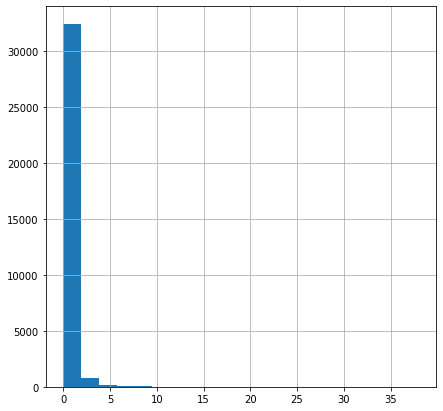

In [187]:


hist = snd_nei_raw_df['LABEL_bubbleStore_cnt_snd_agg'].hist(bins=20,
       figsize=[7, 7])

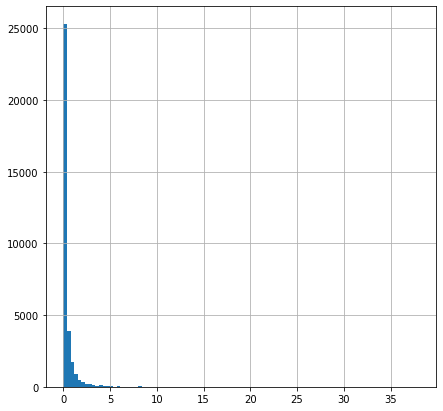

In [190]:

hist = fst_nei_raw_df['LABEL_bubbleStore_cnt_fst_agg'].hist(bins=100,
       figsize=[7, 7])

In [192]:
len(fst_nei_raw_df[fst_nei_raw_df['LABEL_bubbleStore_cnt_fst_agg']==0])/len(fst_nei_raw_df)

0.5132877978942345

In [193]:
len(snd_nei_raw_df[snd_nei_raw_df['LABEL_bubbleStore_cnt_snd_agg']==0])/len(snd_nei_raw_df)

0.3363259462522743